In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 

In [2]:
holdings = pd.read_csv("Warren_Buffett_final_df_with_ticker.csv")
fundamentals = pd.ExcelFile("Warren_Buffett_Analysis.xlsx")
SP500_quarterly_df = pd.read_csv("SP500_quarterly_data.csv")

SP500_quarterly_df["Date"] = pd.to_datetime(SP500_quarterly_df["Date"])
holdings["date"] = pd.to_datetime(holdings["date"])

snapshots = {}
dates = holdings["date"].unique()
print(dates)

<DatetimeArray>
['2024-08-14 00:00:00', '2024-11-14 00:00:00', '2025-02-14 00:00:00',
 '2025-05-15 00:00:00']
Length: 4, dtype: datetime64[ns]


In [3]:
def change_dates(df):
    date_map = {
        "2024-06-30 00:00:00": "2024-08-14 00:00:00",
        "2024-09-30 00:00:00": "2024-11-14 00:00:00",
        "2024-12-31 00:00:00": "2025-02-14 00:00:00",
        "2025-03-31 00:00:00": "2025-05-15 00:00:00",
        "2025-06-30 00:00:00": "2025-08-14 00:00:00"
    }
    df["date"] = df["date"].astype(str).replace(date_map)
    df["date"] = pd.to_datetime(df["date"])
    return df

BF_financials_df = fundamentals.parse("Financials")
BF_balance_sheets_df = fundamentals.parse("Balance_Sheets")
BF_cashflow_df = fundamentals.parse("Cashflow")
BF_profitability_df = fundamentals.parse("Profitability")
BF_growth_df = fundamentals.parse("Growth")
BF_Financial_health_df = fundamentals.parse("Financial_Health")
BF_fundamental_df = fundamentals.parse("Valuation")


# Fill missing tickers
BF_profitability_df["ticker"] = BF_profitability_df["ticker"].ffill()
BF_growth_df["ticker"] = BF_growth_df["ticker"].ffill()
BF_Financial_health_df["ticker"] = BF_Financial_health_df["ticker"].ffill()
BF_fundamental_df["ticker"] = BF_fundamental_df["ticker"].ffill()
BF_balance_sheets_df["ticker"] = BF_balance_sheets_df["ticker"].ffill()

# Merge quarterly features
BF_quarterly_features_df = (
    BF_profitability_df[["ticker", "date", "ROE", "ROA", "Profit Margin", "Operating Margin", "Gross Margin"]]
    .merge(BF_growth_df[["ticker", "date", "Revenue Growth", "Earnings Growth"]], on=["ticker", "date"], how="outer")
    .merge(BF_Financial_health_df[["ticker", "date", "Debt Ratio", "Debt to Equity Ratio", "Current Ratio", "Free Cash Flow"]], on=["ticker", "date"], how="outer")
)

# Apply date mapping
BF_quarterly_features_df = change_dates(BF_quarterly_features_df)

# Valuation features
BF_valuation_features_df = BF_fundamental_df[["ticker", "trailingPE", "priceToBook", "enterpriseToEbitda", "marketCap", "dividendYield"]]


In [4]:
print(BF_quarterly_features_df.shape)

(263, 13)


In [5]:
BF_final_df = BF_quarterly_features_df.merge(BF_valuation_features_df, on="ticker", how="left")
print(BF_final_df)
print(BF_final_df.shape)
print(BF_final_df.columns)

    ticker       date       ROE       ROA  Profit Margin  Operating Margin  \
0     AAPL 2023-12-31       NaN       NaN            NaN               NaN   
1     AAPL 2024-03-31       NaN       NaN            NaN               NaN   
2     AAPL 2024-06-30  0.321521  0.064678       0.250044          0.295557   
3     AAPL 2024-09-30  0.258753  0.040375       0.155230          0.311714   
4     AAPL 2024-12-31  0.544204  0.105584       0.292277          0.344586   
..     ...        ...       ...       ...            ...               ...   
258   VRSN 2024-06-30 -0.109447  0.132084       0.513562          0.687678   
259   VRSN 2024-09-30 -0.105914  0.137688       0.515361          0.689452   
260   VRSN 2024-12-31 -0.097809  0.136154       0.484320          0.667172   
261   VRSN 2025-03-31 -0.100809  0.137667       0.495401          0.674124   
262   VRSN 2025-06-30 -0.104022  0.147322       0.505977          0.684801   

     Gross Margin  Revenue Growth  Earnings Growth  Debt Ratio 

In [6]:
sp500_analysis = pd.ExcelFile("SP500_Analysis.xlsx")

financials_df = sp500_analysis.parse("Financials")
balance_sheets_df = sp500_analysis.parse("Balance_Sheets")
cashflow_df = sp500_analysis.parse("Cashflow")
profitability_df = sp500_analysis.parse("Profitability")
growth_df = sp500_analysis.parse("Growth")
Financial_health_df = sp500_analysis.parse("Financial_Health")
fundamental_df = sp500_analysis.parse("Valuation")

profitability_df["ticker"] = profitability_df["ticker"].ffill()
growth_df["ticker"] = growth_df["ticker"].ffill()
Financial_health_df["ticker"] = Financial_health_df["ticker"].ffill()
fundamental_df["ticker"] = fundamental_df["ticker"].ffill()
balance_sheets_df["ticker"] = balance_sheets_df["ticker"].ffill()

sp_quarterly_features_df = (
    profitability_df[["ticker", "date", "ROE", "ROA", "Profit Margin", "Operating Margin", "Gross Margin"]]
    .merge(growth_df[["ticker", "date", "Revenue Growth", "Earnings Growth"]], on=["ticker", "date"], how="outer")
    .merge(Financial_health_df[["ticker", "date", "Debt Ratio", "Debt to Equity Ratio", "Current Ratio", "Free Cash Flow"]], on=["ticker", "date"], how="outer")
)

sp_valuation_features_df = fundamental_df[["ticker", "trailingPE", "priceToBook", "enterpriseToEbitda", "marketCap", "dividendYield"]]

# print(quarterly_features_df)
# print(valuation_features_df)

sp_final_df = sp_quarterly_features_df.merge(sp_valuation_features_df, how="outer")

In [7]:
print("Unique BF dates:", BF_final_df["date"].unique())
print("Unique SP500 dates:", sp_final_df["date"].unique())
print("Holdings dates:", dates)
print(sp_final_df.shape)

sp_final_df = sp_final_df[sp_final_df["date"] != "2023-12-31"]
sp_final_df = change_dates(sp_final_df)
print(sp_final_df.shape)
print(sp_final_df['date'])

print()
print("Unique BF dates:", BF_final_df["date"].unique())
print("Unique SP500 dates:", sp_final_df["date"].unique())
print("Holdings dates:", dates)

Unique BF dates: <DatetimeArray>
['2023-12-31 00:00:00', '2024-03-31 00:00:00', '2024-06-30 00:00:00',
 '2024-09-30 00:00:00', '2024-12-31 00:00:00', '2025-03-31 00:00:00',
 '2025-06-30 00:00:00', '2023-11-30 00:00:00', '2024-02-29 00:00:00',
 '2024-05-31 00:00:00', '2024-08-31 00:00:00', '2024-11-30 00:00:00',
 '2025-02-28 00:00:00', '2025-05-31 00:00:00', '2024-01-31 00:00:00',
 '2024-04-30 00:00:00', '2024-07-31 00:00:00', '2024-10-31 00:00:00',
 '2025-01-31 00:00:00', '2025-04-30 00:00:00']
Length: 20, dtype: datetime64[ns]
Unique SP500 dates: ['2024-01-31' '2024-04-30' '2024-07-31' '2024-10-31' '2025-01-31'
 '2025-04-30' '2023-12-31' '2024-03-31' '2024-06-30' '2024-09-30'
 '2024-12-31' '2025-03-31' '2025-06-30' '2024-02-29' '2024-05-31'
 '2024-08-31' '2024-11-30' '2025-02-28' '2025-05-31' '2025-07-31']
Holdings dates: <DatetimeArray>
['2024-08-14 00:00:00', '2024-11-14 00:00:00', '2025-02-14 00:00:00',
 '2025-05-15 00:00:00']
Length: 4, dtype: datetime64[ns]
(3258, 18)
(2844, 18)


In [8]:
reverse_date_map = {
    pd.to_datetime("2024-08-14"): pd.to_datetime("2024-06-30"),
    pd.to_datetime("2024-11-14"): pd.to_datetime("2024-09-30"),
    pd.to_datetime("2025-02-14"): pd.to_datetime("2024-12-31"),
    pd.to_datetime("2025-05-15"): pd.to_datetime("2025-03-31"),
}

snapshots = {}
for hold_date in dates:  
    mapped_date = reverse_date_map.get(hold_date, None)
    if mapped_date is None:
        continue  # skip if no mapping
    
    temp_BF = BF_final_df[BF_final_df["date"] == mapped_date]
    temp_SP = sp_final_df[sp_final_df["date"] == mapped_date]
    
    if not temp_BF.empty or not temp_SP.empty:
        # temp_merge = temp_BF.merge(temp_SP, how="outer", on="date")
        temp_merge = temp_BF.merge(
        temp_SP, 
        how="outer", 
        on=["ticker", "date"] )
        snapshots[hold_date] = temp_merge

print({k: v.shape for k, v in snapshots.items()})
# Rebuild graphs dict with simple string keys
snapshots = {str(k.date()): v for k, v in snapshots.items()}

print(snapshots.keys())
# dict_keys(['2024-08-14', '2024-11-14', '2025-02-14', '2025-05-15'])



{Timestamp('2024-08-14 00:00:00'): (449, 34), Timestamp('2024-11-14 00:00:00'): (448, 34), Timestamp('2025-02-14 00:00:00'): (449, 34), Timestamp('2025-05-15 00:00:00'): (448, 34)}
dict_keys(['2024-08-14', '2024-11-14', '2025-02-14', '2025-05-15'])


In [9]:
G = snapshots["2024-08-14"]
print(G.shape)
print(G.columns)

(449, 34)
Index(['ticker', 'date', 'ROE_x', 'ROA_x', 'Profit Margin_x',
       'Operating Margin_x', 'Gross Margin_x', 'Revenue Growth_x',
       'Earnings Growth_x', 'Debt Ratio_x', 'Debt to Equity Ratio_x',
       'Current Ratio_x', 'Free Cash Flow_x', 'trailingPE_x', 'priceToBook_x',
       'enterpriseToEbitda_x', 'marketCap_x', 'dividendYield_x', 'ROE_y',
       'ROA_y', 'Profit Margin_y', 'Operating Margin_y', 'Gross Margin_y',
       'Revenue Growth_y', 'Earnings Growth_y', 'Debt Ratio_y',
       'Debt to Equity Ratio_y', 'Current Ratio_y', 'Free Cash Flow_y',
       'trailingPE_y', 'priceToBook_y', 'enterpriseToEbitda_y', 'marketCap_y',
       'dividendYield_y'],
      dtype='object')


In [ ]:
def create_buffett_graph(snapshot_df, holdings_df, date_str):
    G = nx.Graph()

    date_holdings = holdings_df[holdings_df['date'] == pd.to_datetime(date_str)]
    buffett_stocks = set(date_holdings['ticker'].unique())
    
    # Get all stocks in the snapshot
    all_stocks = set(snapshot_df['ticker'].dropna().unique())
    
    # Add Buffett node with appropriate label
    buffett_label = 1 if len(buffett_stocks) > 0 else 0
    G.add_node('Warren_Buffett', label=buffett_label, node_type='investor')
    
    # Add stock nodes
    for ticker in all_stocks:
        stock_data = snapshot_df[snapshot_df['ticker'] == ticker].iloc[0]
        
        node_attrs = {
            'label': 1 if ticker in buffett_stocks else 0,  
            'node_type': 'stock',
            'ticker': ticker
        }
        
        # Add financial features as node attributes
        financial_features = ['ROE_y', 'ROA_y', 'Profit Margin_y', 'Operating Margin_y', 
                            'Gross Margin_y', 'Revenue Growth_y', 'Earnings Growth_y',
                            'Debt Ratio_y', 'Current Ratio_y', 'trailingPE_y', 
                            'priceToBook_y', 'marketCap_y', 'dividendYield_y']
        
        for feature in financial_features:
            if feature in stock_data and pd.notna(stock_data[feature]):
                node_attrs[feature.replace('_y', '')] = stock_data[feature]
        
        G.add_node(ticker, **node_attrs)
        
        if ticker in buffett_stocks:
            G.add_edge('Warren_Buffett', ticker, relationship='owns')
    
    return G

# Create graphs for each date
graphs = {}
for date_str in snapshots.keys():
    snapshot_df = snapshots[date_str]
    graph = create_buffett_graph(snapshot_df, holdings, date_str)
    graphs[date_str] = graph
    
    print(f"Date {date_str}: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")
    
    # # Check Buffett's connections
    # buffett_neighbors = list(graph.neighbors('Warren_Buffett'))
    # print(f"  Buffett connected to {len(buffett_neighbors)} stocks: {buffett_neighbors[:5]}...")
    
    # # Verify no edges to non-owned stocks
    # date_holdings = holdings[holdings['date'] == pd.to_datetime(date_str)]
    # owned_stocks = set(date_holdings['ticker'].unique())
    
    # for neighbor in buffett_neighbors:
    #     if neighbor not in owned_stocks:
    #         print(f"  ERROR: Buffett connected to non-owned stock {neighbor}")
    
    print()

Date 2024-08-14: 450 nodes, 32 edges
  Buffett connected to 32 stocks: ['NVR', 'MCO', 'V', 'SIRI', 'AAPL']...

Date 2024-11-14: 449 nodes, 32 edges
  Buffett connected to 32 stocks: ['NVR', 'MCO', 'V', 'SIRI', 'AAPL']...

Date 2025-02-14: 450 nodes, 33 edges
  Buffett connected to 33 stocks: ['NVR', 'MCO', 'V', 'SIRI', 'AAPL']...

Date 2025-05-15: 449 nodes, 30 edges
  Buffett connected to 30 stocks: ['NVR', 'MCO', 'V', 'SIRI', 'AAPL']...



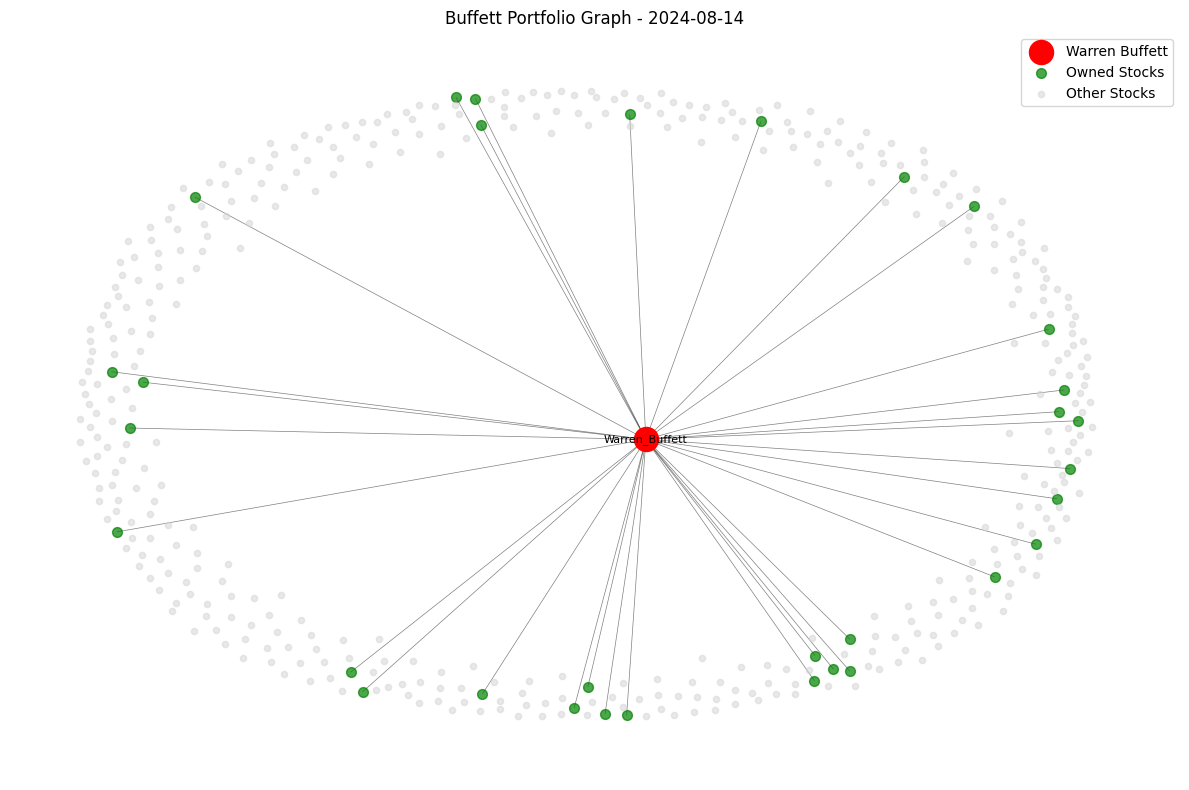

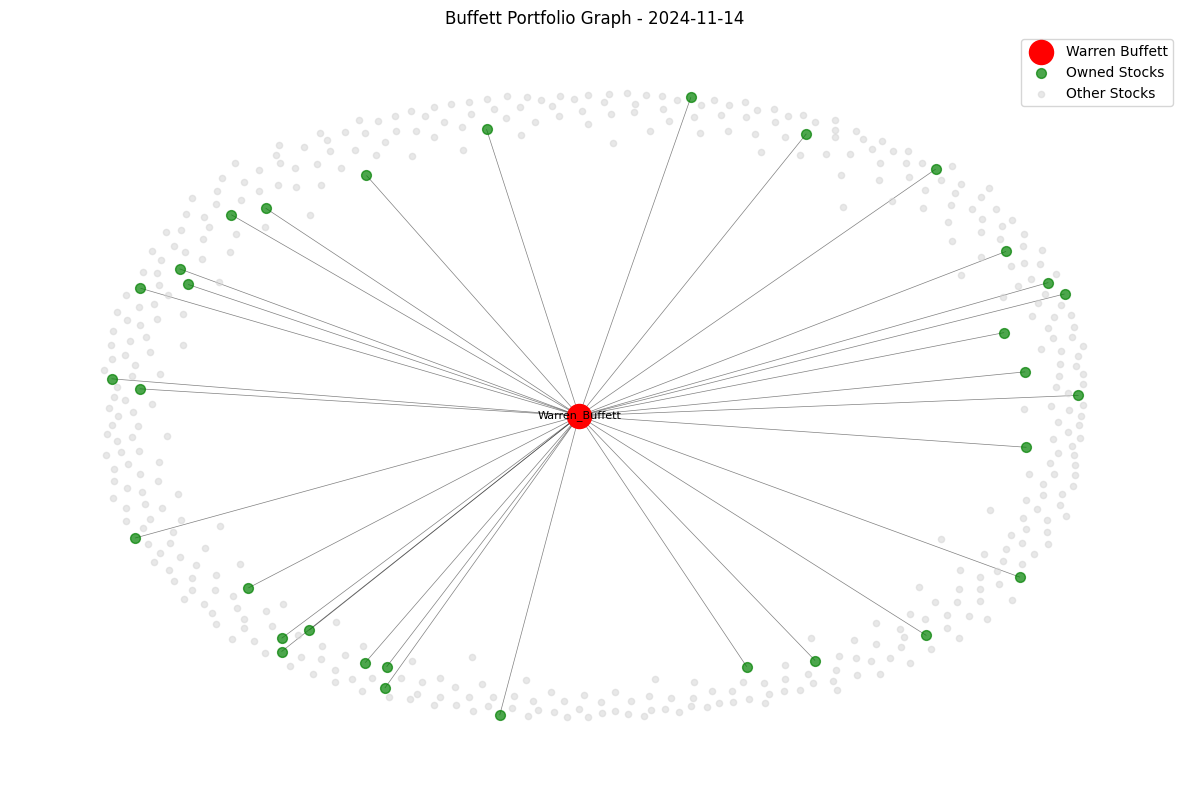

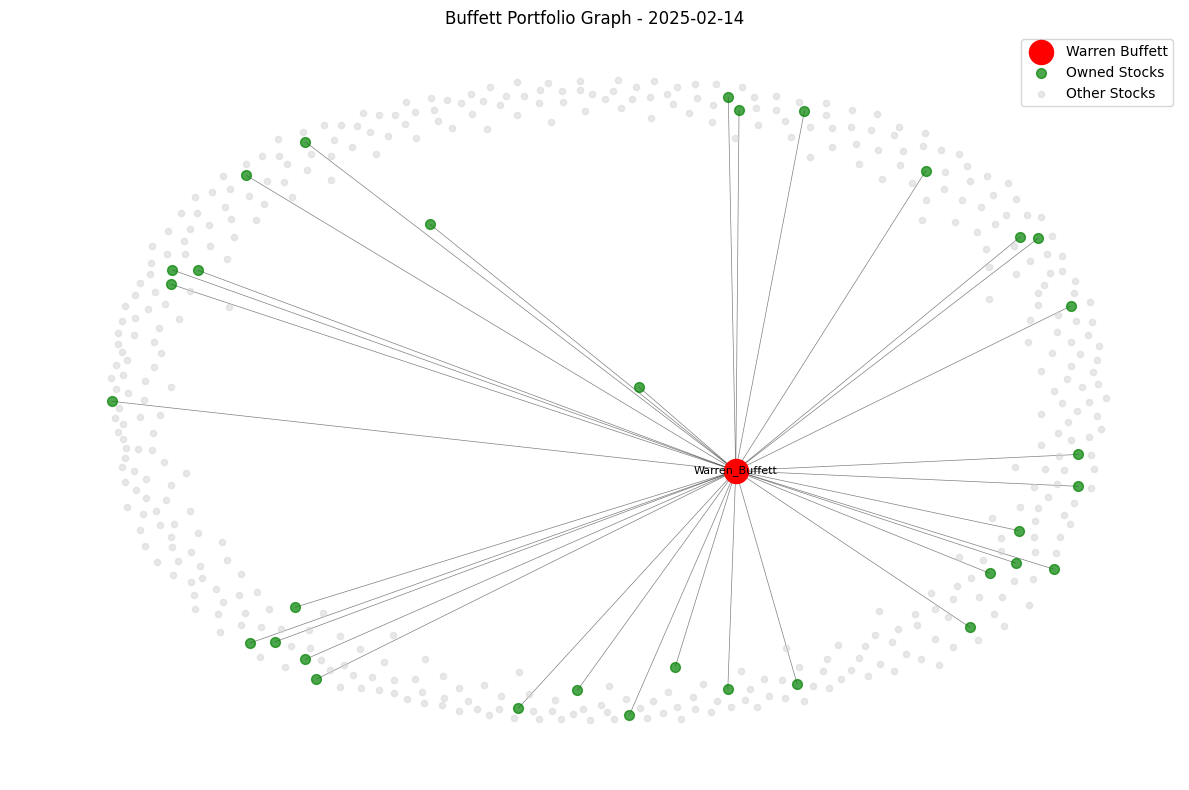

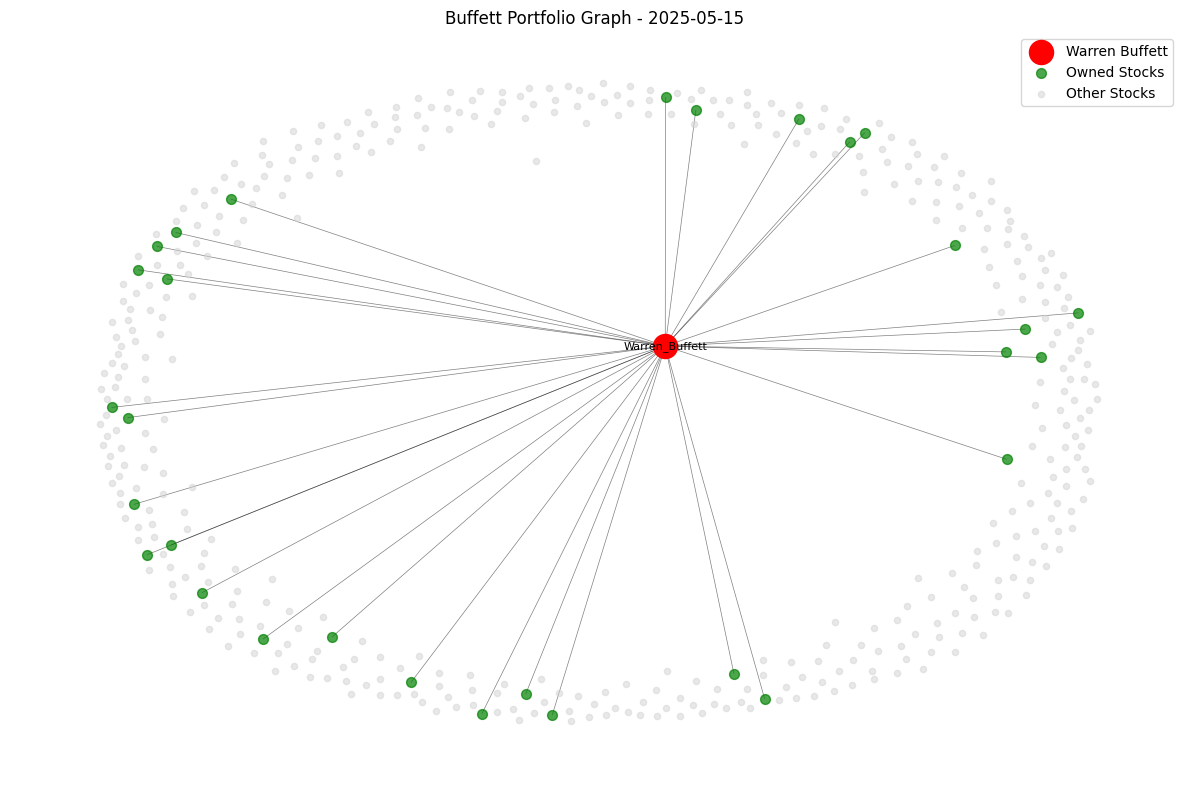

In [ ]:
# Visualize graph 
def visualize_buffett_graph(graph, title="Buffett Stock Ownership Graph"):
    plt.figure(figsize=(12, 8))
    
    # Create layout
    pos = nx.spring_layout(graph, k=1, iterations=50)
    
    # Separate nodes by type
    buffett_nodes = [n for n in graph.nodes() if graph.nodes[n].get('node_type') == 'investor']
    owned_stocks = [n for n in graph.nodes() if graph.nodes[n].get('node_type') == 'stock' and graph.nodes[n].get('label') == 1]
    unowned_stocks = [n for n in graph.nodes() if graph.nodes[n].get('node_type') == 'stock' and graph.nodes[n].get('label') == 0]
    
    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=buffett_nodes, 
                          node_color='red', node_size=300, label='Warren Buffett')
    nx.draw_networkx_nodes(graph, pos, nodelist=owned_stocks, 
                          node_color='green', node_size=50, alpha=0.7, label='Owned Stocks')
    nx.draw_networkx_nodes(graph, pos, nodelist=unowned_stocks, 
                          node_color='lightgray', node_size=20, alpha=0.5, label='Other Stocks')
    
    # Draw edges (only between Buffett and owned stocks)
    nx.draw_networkx_edges(graph, pos, alpha=0.5, width=0.5)
    
    # Add labels for Buffett
    buffett_labels = {n: n for n in buffett_nodes}
    nx.draw_networkx_labels(graph, pos, labels=buffett_labels, font_size=8)
    
    plt.title(title)
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# # Visualize the first graph
# first_date = list(graphs.keys())[0]
# visualize_buffett_graph(graphs[first_date], f"Buffett Portfolio Graph - {first_date}")

for graph in graphs:
    visualize_buffett_graph(graphs[graph], f"Buffett Portfolio Graph - {graph}")

In [ ]:
# Fixed labeling function
def add_label_fixed(df, date_str):
    df_copy = df.copy()
    
    # Convert date_str to datetime for matching
    target_date = pd.to_datetime(date_str).normalize()
    
    # Get holdings for this specific date
    date_holdings = holdings[holdings['date'] == target_date]
    owned_tickers = set(date_holdings['ticker'].unique())
    
    print(f"\nProcessing date {date_str} (normalized: {target_date})")
    print(f"Found {len(owned_tickers)} owned tickers: {list(owned_tickers)[:10]}...")
    
    # Simple ticker-based labeling (since we know the date)
    df_copy["Buffett_Owned"] = df_copy['ticker'].apply(
        lambda ticker: 1 if ticker in owned_tickers else 0
    )
    
    return df_copy, owned_tickers

# Apply fixed labeling
fixed_labeled_snapshots = {}
for date_str, snapshot_df in snapshots.items():
    labeled_df, owned_tickers = add_label_fixed(snapshot_df, date_str)
    fixed_labeled_snapshots[date_str] = labeled_df
    
    print(f"\nResults for {date_str}:")
    print(f"  Total stocks: {len(labeled_df)}")
    print(f"  Buffett owned (expected): {len(owned_tickers)}")
    print(f"  Buffett owned (labeled): {labeled_df['Buffett_Owned'].sum()}")
    print(f"  Labeling success: {'✓' if labeled_df['Buffett_Owned'].sum() == len(owned_tickers) else '✗'}")
    
    # # Show some examples
    # owned_examples = labeled_df[labeled_df['Buffett_Owned'] == 1]['ticker'].head(5).tolist()
    # not_owned_examples = labeled_df[labeled_df['Buffett_Owned'] == 0]['ticker'].head(5).tolist()
    # print(f"  Owned examples: {owned_examples}")
    # print(f"  Not owned examples: {not_owned_examples}")



Processing date 2024-08-14 (normalized: 2024-08-14 00:00:00)
Found 41 owned tickers: ['AXP', 'VOO', 'AON', 'DEO', 'NU', 'KHC', 'KO', 'SPY', 'BAC', 'DVA']...

Results for 2024-08-14:
  Total stocks: 449
  Buffett owned (expected): 41
  Buffett owned (labeled): 32
  Labeling success: ✗
  Owned examples: ['AAPL', 'ALLY', 'AMZN', 'AON', 'AXP']
  Not owned examples: ['ABBV', 'ABNB', 'ABT', 'ACGL', 'ADM']
  AAPL label: 1 (expected: 1) ✓

Processing date 2024-11-14 (normalized: 2024-11-14 00:00:00)
Found 40 owned tickers: ['AXP', 'VOO', 'AON', 'DEO', 'NU', 'KHC', 'KO', 'SPY', 'BAC', 'ULTA']...

Results for 2024-11-14:
  Total stocks: 448
  Buffett owned (expected): 40
  Buffett owned (labeled): 32
  Labeling success: ✗
  Owned examples: ['AAPL', 'ALLY', 'AMZN', 'AON', 'AXP']
  Not owned examples: ['ABBV', 'ABNB', 'ABT', 'ACGL', 'ADM']
  AAPL label: 1 (expected: 1) ✓

Processing date 2025-02-14 (normalized: 2025-02-14 00:00:00)
Found 38 owned tickers: ['AXP', 'AON', 'DEO', 'NU', 'KHC', 'STZ',

In [13]:
def combine_duplicate_columns(df):
    df_combined = df.copy()
    
    # Find all column pairs with _x and _y suffixes
    x_columns = [col for col in df.columns if col.endswith('_x')]
    y_columns = [col for col in df.columns if col.endswith('_y')]
    
    # Get base column names
    x_base_names = [col[:-2] for col in x_columns]
    y_base_names = [col[:-2] for col in y_columns]
    
    # Find common base names
    common_base_names = set(x_base_names) & set(y_base_names)
    
    # Combine each pair
    for base_name in common_base_names:
        x_col = base_name + '_x'
        y_col = base_name + '_y'
        
        if x_col in df.columns and y_col in df.columns:
            # Combine: use _x values, fill NaN with _y values
            df_combined[base_name] = df_combined[x_col].fillna(df_combined[y_col])
            
            # Drop the original _x and _y columns
            df_combined = df_combined.drop(columns=[x_col, y_col])
    
    return df_combined

final_snapshots = {}
for date_str, labelled_df in fixed_labeled_snapshots.items():
    combined_df = combine_duplicate_columns(labelled_df)
    final_snapshots[date_str] = combined_df
    print(f"Date {date_str}")
    print(f"Shape {combined_df.shape}")
    print(combined_df)

Date 2024-08-14
Shape (449, 19)
    ticker       date  Buffett_Owned  Current Ratio  Gross Margin  \
0     AAPL 2024-06-30              1       0.952980      0.462572   
1     ABBV 2024-06-30              0       0.806776      0.709445   
2     ABNB 2024-06-30              0       1.405863      0.815866   
3      ABT 2024-06-30              0       1.680160      0.556423   
4     ACGL 2024-06-30              0            NaN           NaN   
..     ...        ...            ...            ...           ...   
444   WYNN 2024-06-30              0       1.296609      0.434865   
445    XEL 2024-06-30              0       0.965932      0.459709   
446    XOM 2024-06-30              0       1.360005      0.224435   
447    XYL 2024-06-30              0       1.851616      0.377593   
448    XYZ 2024-06-30              0       1.822569      0.362839   

     Free Cash Flow  enterpriseToEbitda       ROE  priceToBook  trailingPE  \
0      2.670700e+10              24.582  0.321521    52.26585

In [14]:
from sklearn.model_selection import train_test_split

def proper_data_speration(df):
    train_data, test_data = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df["Buffett_Owned"]
    )

    print(f"Training data: {len(train_data)} samples")
    print(f"Test data: {len(test_data)} samples")
    print(f"Training positive samples: {len(train_data[train_data['Buffett_Owned'] == 1])}")
    print(f"Test positive samples: {len(test_data[test_data['Buffett_Owned'] == 1])}")
    return train_data, test_data

splits = {}

for date, df in final_snapshots.items():
    print(f"\nSnapshot {date}")
    train, test = proper_data_speration(df)
    splits[date] = {"train": train, "test": test}


Snapshot 2024-08-14
Training data: 359 samples
Test data: 90 samples
Training positive samples: 26
Test positive samples: 6

Snapshot 2024-11-14
Training data: 358 samples
Test data: 90 samples
Training positive samples: 26
Test positive samples: 6

Snapshot 2025-02-14
Training data: 359 samples
Test data: 90 samples
Training positive samples: 26
Test positive samples: 7

Snapshot 2025-05-15
Training data: 358 samples
Test data: 90 samples
Training positive samples: 24
Test positive samples: 6


In [15]:
def create_buffett_features(df):
    """Create features that align with Buffett's investment philosophy"""
    df = df.copy()
    
    # Value Score (lower is better for Buffett)
    df['value_score'] = (
        (df['trailingPE'].fillna(df['trailingPE'].median()) / 20) +  # Normalize PE
        (df['priceToBook'].fillna(df['priceToBook'].median()) / 3)   # Normalize PB
    ) / 2
    
    # Quality Score (higher is better)
    df['quality_score'] = (
        df['ROE'].fillna(0) * 2 +  # Weight ROE heavily
        df['ROA'].fillna(0) * 1.5 +
        df['Profit Margin'].fillna(0) * 1.2
    ) / 4.7
    
    # Financial Stability Score (lower debt, higher cash flow is better)
    df['stability_score'] = (
        (1 - df['Debt Ratio'].fillna(0.5)) * 0.4 +  # Lower debt ratio is better
        df['Current Ratio'].fillna(1) * 0.3 +       # Higher current ratio is better
        np.where(df['Free Cash Flow'] > 0, 1, 0) * 0.3  # Positive FCF is good
    )
    
    # Dividend Yield (Buffett likes dividend-paying stocks)
    df['has_dividend'] = np.where(df['dividendYield'].fillna(0) > 0, 1, 0)
    df['dividend_score'] = df['dividendYield'].fillna(0) / 5  # Normalize
    
    # Market Cap (Buffett prefers large, established companies)
    df['large_cap'] = np.where(df['marketCap'] > 10e9, 1, 0)  # >$10B market cap
    
    # Sustainable Growth (positive but not excessive)
    df['sustainable_growth'] = np.where(
        (df['Revenue Growth'].fillna(0) > 0) & (df['Revenue Growth'].fillna(0) < 0.3), 1, 0
    )
    
    return df

for date, split in splits.items():
    print(f"\n=== Enhancing Snapshot {date} ===")
    
    # Apply feature creation on both train and test
    split["train"] = create_buffett_features(split["train"])
    split["test"] = create_buffett_features(split["test"])
    
    print(f"Train shape: {split['train'].shape}, Test shape: {split['test'].shape}")
    print("Sample features added:")
    print(split["train"][['ticker', 'value_score', 'quality_score',
                          'stability_score', 'dividend_score',
                          'large_cap', 'sustainable_growth']].head())


=== Enhancing Snapshot 2024-08-14 ===
Train shape: (359, 26), Test shape: (90, 26)
Sample features added:
    ticker  value_score  quality_score  stability_score  dividend_score  \
157   FAST     3.699814       0.094924         1.971758           0.354   
5      ADM     0.904285       0.017858         1.042772           0.652   
174   GDDY     9.149357       0.435795         0.640479           0.000   
324    PFG     0.668145       0.034921         0.994841           0.776   
280    MOH     0.576593       0.040552         0.809292           0.000   

     large_cap  sustainable_growth  
157          1                   0  
5            1                   0  
174          1                   0  
324          1                   0  
280          0                   0  

=== Enhancing Snapshot 2024-11-14 ===
Train shape: (358, 26), Test shape: (90, 26)
Sample features added:
    ticker  value_score  quality_score  stability_score  dividend_score  \
190    HAL     0.574403       0.056384

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Model Training
feature_columns = [
    'ROE', 'ROA', 'Profit Margin', 'Operating Margin', 'Gross Margin',
    'Revenue Growth', 'Earnings Growth', 'Debt Ratio', 'Debt to Equity Ratio',
    'Current Ratio', 'trailingPE', 'priceToBook', 'enterpriseToEbitda',
    'marketCap', 'dividendYield',
    'value_score', 'quality_score', 'stability_score', 'has_dividend',
    'dividend_score', 'large_cap', 'sustainable_growth'
]
def model_training(split):
    """Train a model on the given split"""
    X_train = split["train"][feature_columns]
    y_train = split["train"]["Buffett_Owned"]

    X_test = split["test"][feature_columns]
    y_test = split["test"]["Buffett_Owned"]

    # Handle nan
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_test = X_test.replace([np.inf, -np.inf], np.nan)

    print(f"Training features shape: {X_train.shape}")
    print(f"Training labels distribution:\n{y_train.value_counts()}")
    print(f"Test features shape: {X_test.shape}")
    print(f"Test labels distribution:\n{y_test.value_counts()}")

    # Pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('classifier', RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',  # Handle imbalance
            random_state=42
        ))
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Cross-validation on training set
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"\nCross-validation AUC scores: {cv_scores}")
    print(f"Mean CV AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, pipeline.predict(X_train)))

    # Evaluate on test set
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print("\nTest Set Evaluation:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    if len(np.unique(y_test)) > 1:
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

    return {
        "model": pipeline,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

results = {}
for date, split in splits.items():
    print(f"\n===== Training on {date} =====")
    results[date] = model_training(split)




===== Training on 2024-08-14 =====
Training features shape: (359, 22)
Training labels distribution:
Buffett_Owned
0    333
1     26
Name: count, dtype: int64
Test features shape: (90, 22)
Test labels distribution:
Buffett_Owned
0    84
1     6
Name: count, dtype: int64

Cross-validation AUC scores: [0.70746269 0.72835821 0.62089552 0.80050505 0.68181818]
Mean CV AUC: 0.708 (+/- 0.117)
Train Confusion Matrix:
[[333   0]
 [  0  26]]

Test Set Evaluation:
Confusion Matrix:
[[83  1]
 [ 5  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97        84
           1       0.50      0.17      0.25         6

    accuracy                           0.93        90
   macro avg       0.72      0.58      0.61        90
weighted avg       0.91      0.93      0.92        90

ROC AUC Score: 0.607

===== Training on 2024-11-14 =====
Training features shape: (358, 22)
Training labels distribution:
Buffett_Owned
0    332
1     26


In [17]:
# Using SMOTE + XGBoost
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

feature_columns = [
    'ROE', 'ROA', 'Profit Margin', 'Operating Margin', 'Gross Margin',
    'Revenue Growth', 'Earnings Growth', 'Debt Ratio', 'Debt to Equity Ratio',
    'Current Ratio', 'trailingPE', 'priceToBook', 'enterpriseToEbitda',
    'marketCap', 'dividendYield',
    'value_score', 'quality_score', 'stability_score', 'has_dividend',
    'dividend_score', 'large_cap', 'sustainable_growth'
]

def model_training_xgb(split):
    """Train a model on the given split with SMOTE and XGBoost"""
    X_train = split["train"][feature_columns].replace([np.inf, -np.inf], np.nan)
    y_train = split["train"]["Buffett_Owned"]

    X_test = split["test"][feature_columns].replace([np.inf, -np.inf], np.nan)
    y_test = split["test"]["Buffett_Owned"]

    print(f"Training features shape: {X_train.shape}")
    print(f"Training labels distribution:\n{y_train.value_counts()}")
    print(f"Test features shape: {X_test.shape}")
    print(f"Test labels distribution:\n{y_test.value_counts()}")

    # Pipeline with SMOTE + XGBoost
    pipeline = ImbPipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
        ('classifier', XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ))
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Evaluate on train
    y_train_pred = pipeline.predict(X_train)
    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    print("\nTrain Evaluation:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

    # Evaluate on test
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print("\nTest Set Evaluation:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    if len(np.unique(y_test)) > 1:
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        print(f"PR AUC: {auc(recall, precision):.3f}")

    return {
        "model": pipeline,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

# Apply to all splits
results_xgb = {}
for date, split in splits.items():
    print(f"\n===== Training on {date} (XGBoost + Balanced) =====")
    results_xgb[date] = model_training_xgb(split)



===== Training on 2024-08-14 (XGBoost + Balanced) =====
Training features shape: (359, 22)
Training labels distribution:
Buffett_Owned
0    333
1     26
Name: count, dtype: int64
Test features shape: (90, 22)
Test labels distribution:
Buffett_Owned
0    84
1     6
Name: count, dtype: int64

Train Evaluation:
[[333   0]
 [  0  26]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       333
           1       1.00      1.00      1.00        26

    accuracy                           1.00       359
   macro avg       1.00      1.00      1.00       359
weighted avg       1.00      1.00      1.00       359


Test Set Evaluation:
[[78  6]
 [ 5  1]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.93        84
           1       0.14      0.17      0.15         6

    accuracy                           0.88        90
   macro avg       0.54      0.55      0.54        90
weighted avg       0.89   

In [18]:
# Cross-Validation
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

feature_columns = [
    'ROE', 'ROA', 'Profit Margin', 'Operating Margin', 'Gross Margin',
    'Revenue Growth', 'Earnings Growth', 'Debt Ratio', 'Debt to Equity Ratio',
    'Current Ratio', 'trailingPE', 'priceToBook', 'enterpriseToEbitda',
    'marketCap', 'dividendYield',
    'value_score', 'quality_score', 'stability_score', 'has_dividend',
    'dividend_score', 'large_cap', 'sustainable_growth'
]

def add_buffett_features(df):
    """Add Buffett-specific investment features"""
    df = df.copy()
    df['debt_ratio_inv'] = 1 / (df['Debt Ratio'] + 0.01)
    df['roe_stability'] = df['ROE'] * df['stability_score']
    df['quality_value'] = df['quality_score'] * df['value_score']
    df['buffett_score'] = (df['ROE'] * 0.3 + df['debt_ratio_inv'] * 0.2 + 
                          df['stability_score'] * 0.3 + df['dividend_score'] * 0.2)
    return df

def find_recall_threshold(y_true, y_proba, target_recall=0.5):
    """Find optimal threshold for target recall"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    
    min_len = min(len(precision), len(recall), len(thresholds))
    precision = precision[:min_len]
    recall = recall[:min_len]
    thresholds = thresholds[:min_len]
    
    valid_idx = recall >= target_recall
    if np.any(valid_idx):
        valid_thresholds = thresholds[valid_idx]
        valid_precision = precision[valid_idx]
        best_idx = np.argmax(valid_precision)
        best_threshold = valid_thresholds[best_idx]
        return max(best_threshold, 0.1)
    
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_f1_idx = np.argmax(f1_scores)
    return max(thresholds[best_f1_idx], 0.1)

def create_model_pipeline():
    """Create the ML pipeline"""
    return ImbPipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('smote', SMOTEENN(sampling_strategy=0.6, random_state=42)),
        ('classifier', XGBClassifier(
            n_estimators=150,
            max_depth=3,
            learning_rate=0.1,
            scale_pos_weight=20,
            max_delta_step=1,
            subsample=0.8,
            reg_alpha=0.01,  
            random_state=42,
            eval_metric='logloss'
        ))
    ])

def run_cross_validation_analysis(combined_data):    
    # Add Buffett features
    data = add_buffett_features(combined_data)
    new_features = feature_columns + ['debt_ratio_inv', 'roe_stability', 'quality_value', 'buffett_score']
    
    # Prepare data
    X = data[new_features].replace([np.inf, -np.inf], np.nan)
    y = data["Buffett_Owned"]
    
    print(f"Combined data shape: {X.shape}")
    print(f"Label distribution: {y.value_counts().values}")
    print(f"Positive class percentage: {(y.sum() / len(y) * 100):.1f}%")
    
    # Setup cross-validation
    pipeline = create_model_pipeline()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Custom recall scorer for positive class
    recall_scorer = make_scorer(lambda y_true, y_pred: recall_score(y_true, y_pred, pos_label=1), greater_is_better=True)
    
    # Run cross-validation
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    
    cv_roc_auc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    cv_recall = cross_val_score(pipeline, X, y, cv=cv, scoring=recall_scorer, n_jobs=-1)
    cv_f1 = cross_val_score(pipeline, X, y, cv=cv, scoring='f1', n_jobs=-1)
    
    print(f"ROC AUC:    {cv_roc_auc.mean():.3f} ± {cv_roc_auc.std() * 2:.3f}")
    print(f"Recall:     {cv_recall.mean():.3f} ± {cv_recall.std() * 2:.3f}")
    print(f"F1 Score:   {cv_f1.mean():.3f} ± {cv_f1.std() * 2:.3f}")
    
    # Train-test split for final evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )
    
    print(f"\nFinal evaluation split:")
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"Train labels: {y_train.value_counts().values}")
    print(f"Test labels: {y_test.value_counts().values}")
    
    # Create validation split for threshold optimization
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )
    
    # Train model for threshold optimization
    pipeline_thresh = create_model_pipeline()
    pipeline_thresh.fit(X_train_split, y_train_split)
    
    # Find optimal threshold
    val_proba = pipeline_thresh.predict_proba(X_val)[:, 1]
    recall_threshold = find_recall_threshold(y_val, val_proba, target_recall=0.5)
    
    # Train final model on full training data
    final_pipeline = create_model_pipeline()
    final_pipeline.fit(X_train, y_train)
    
    # Final predictions
    y_test_proba = final_pipeline.predict_proba(X_test)[:, 1]
    y_test_pred_default = final_pipeline.predict(X_test)
    y_test_pred_recall = (y_test_proba >= recall_threshold).astype(int)
    
    print("\n" + "="*50)
    print("FINAL TEST RESULTS")
    print("="*50)
    print(f"Optimal recall threshold: {recall_threshold:.3f}")
    
    print("\nDefault Threshold (0.5):")
    print(confusion_matrix(y_test, y_test_pred_default))
    print(classification_report(y_test, y_test_pred_default))
    
    print("\nRecall-Optimized Threshold:")
    print(confusion_matrix(y_test, y_test_pred_recall))
    print(classification_report(y_test, y_test_pred_recall))
    
    # Calculate final metrics
    if len(np.unique(y_test)) > 1:
        test_roc_auc = roc_auc_score(y_test, y_test_proba)
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_proba)
        test_pr_auc = auc(recall_vals, precision_vals)
        print(f"\nFinal Test Metrics:")
        print(f"ROC AUC: {test_roc_auc:.3f}")
        print(f"PR AUC: {test_pr_auc:.3f}")
    
    return {
        "model": final_pipeline,
        "cv_roc_auc": cv_roc_auc.mean(),
        "cv_recall": cv_recall.mean(),
        "cv_f1": cv_f1.mean(),
        "test_roc_auc": test_roc_auc if len(np.unique(y_test)) > 1 else 0,
        "test_pr_auc": test_pr_auc if len(np.unique(y_test)) > 1 else 0,
        "recall_threshold": recall_threshold,
        "y_test": y_test,
        "y_pred_recall": y_test_pred_recall,
        "y_proba": y_test_proba
    }

def combine_and_analyze(splits):
    """Combine all time-based splits and run cross-validation analysis"""
    
    print("COMBINING TIME-BASED SPLITS FOR CROSS-VALIDATION")
    print("="*60)
    
    # Combine all data from different time periods
    all_data = []
    for date, split in splits.items():
        train_data = split["train"].copy()
        test_data = split["test"].copy()
        
        # Add metadata
        train_data['time_period'] = date
        test_data['time_period'] = date
        train_data['split_type'] = 'train'
        test_data['split_type'] = 'test'
        
        all_data.extend([train_data, test_data])
    
    combined_data = pd.concat(all_data, ignore_index=True)
    
    print(f"Original splits: {len(splits)} time periods")
    print(f"Combined dataset: {combined_data.shape[0]} samples, {combined_data.shape[1]} features")
    
    # Run cross-validation analysis
    results = run_cross_validation_analysis(combined_data)
    
    return results

results = combine_and_analyze(splits)

COMBINING TIME-BASED SPLITS FOR CROSS-VALIDATION
Original splits: 4 time periods
Combined dataset: 1794 samples, 28 features
Combined data shape: (1794, 26)
Label distribution: [1667  127]
Positive class percentage: 7.1%

CROSS-VALIDATION RESULTS
ROC AUC:    0.962 ± 0.028
Recall:     0.914 ± 0.090
F1 Score:   0.498 ± 0.072

Final evaluation split:
Train: (1345, 26), Test: (449, 26)
Train labels: [1250   95]
Test labels: [417  32]

FINAL TEST RESULTS
Optimal recall threshold: 0.922

Default Threshold (0.5):
[[377  40]
 [  2  30]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       417
           1       0.43      0.94      0.59        32

    accuracy                           0.91       449
   macro avg       0.71      0.92      0.77       449
weighted avg       0.95      0.91      0.92       449


Recall-Optimized Threshold:
[[410   7]
 [ 11  21]]
              precision    recall  f1-score   support

           0       0.97      0.

In [19]:
# Train on 3 Snapshots, Test on Last
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

feature_columns = [
    'ROE', 'ROA', 'Profit Margin', 'Operating Margin', 'Gross Margin',
    'Revenue Growth', 'Earnings Growth', 'Debt Ratio', 'Debt to Equity Ratio',
    'Current Ratio', 'trailingPE', 'priceToBook', 'enterpriseToEbitda',
    'marketCap', 'dividendYield',
    'value_score', 'quality_score', 'stability_score', 'has_dividend',
    'dividend_score', 'large_cap', 'sustainable_growth'
]

def train_on_three_test_on_last(splits):
    
    dates = sorted(splits.keys())
    train_dates = dates[:3]
    test_date = dates[3]
    
    print("Training on:", ', '.join(train_dates))
    print("Testing on:", test_date)
    print()
    
    # Combine first 3 periods for training
    train_list = []
    for date in train_dates:
        train_list.append(splits[date]["train"])
        train_list.append(splits[date]["test"])
    
    train_combined = pd.concat(train_list, ignore_index=True)
    
    # Last period for testing
    test_combined = pd.concat([
        splits[test_date]["train"],
        splits[test_date]["test"]
    ], ignore_index=True)
    
    # Prepare data
    X_train = train_combined[feature_columns].replace([np.inf, -np.inf], np.nan)
    y_train = train_combined["Buffett_Owned"]
    X_test = test_combined[feature_columns].replace([np.inf, -np.inf], np.nan)
    y_test = test_combined["Buffett_Owned"]
    
    print(f"Train: {X_train.shape}, Labels: {y_train.value_counts().values}")
    print(f"Test: {X_test.shape}, Labels: {y_test.value_counts().values}")
    print()
    
    # Simple pipeline with XGBoost
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('classifier', XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
            random_state=42
        ))
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Results
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    if len(np.unique(y_test)) > 1:
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
    
    return {
        "model": pipeline,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

result = train_on_three_test_on_last(splits)

Training on: 2024-08-14, 2024-11-14, 2025-02-14
Testing on: 2025-05-15

Train: (1346, 22), Labels: [1249   97]
Test: (448, 22), Labels: [418  30]

Confusion Matrix:
[[416   2]
 [  2  28]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       418
           1       0.93      0.93      0.93        30

    accuracy                           0.99       448
   macro avg       0.96      0.96      0.96       448
weighted avg       0.99      0.99      0.99       448

ROC AUC: 0.998


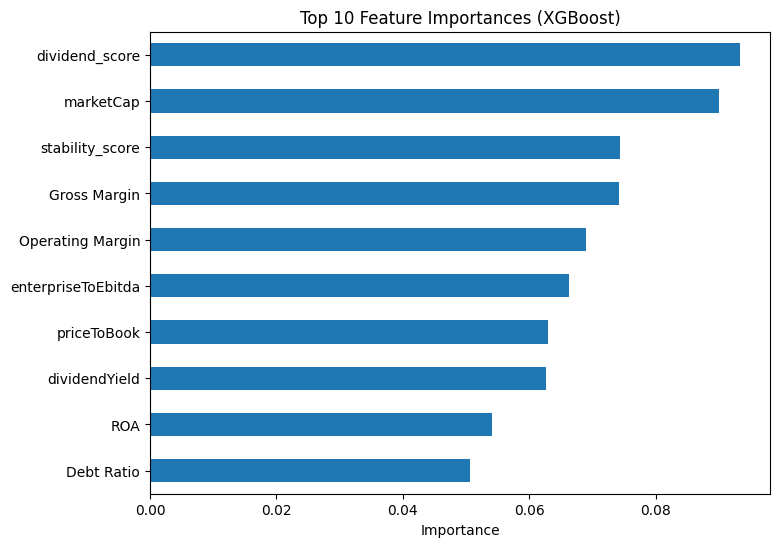

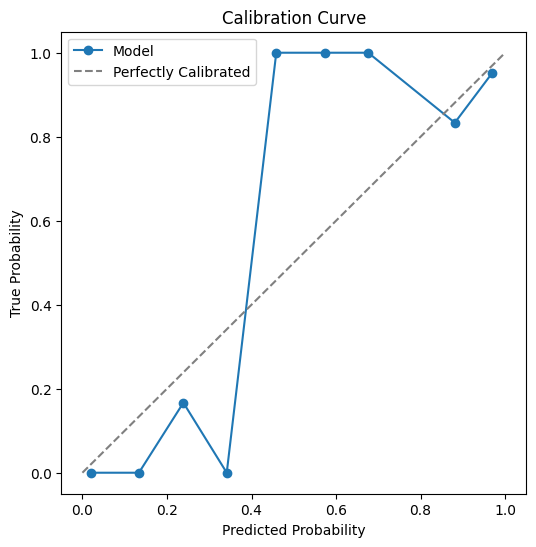

In [20]:
# Checking Feature Importances and Calibration

from sklearn.calibration import calibration_curve

top_n = 10
# Feature Importance
booster = result['model'].named_steps['classifier']
importances = booster.feature_importances_
fi = pd.Series(importances, index=feature_columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
fi.head(top_n).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()

def plot_calibration_curve(y_test, y_proba, n_bins=10):
    """Plot calibration curve"""
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=n_bins)
    
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label="Model")
    plt.plot([0,1],[0,1],'--', color='gray', label="Perfectly Calibrated")
    plt.title("Calibration Curve")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.legend()
    plt.show()

plot_calibration_curve(result["y_test"], result["y_proba"])

In [21]:
# Train on 3 Snapshots, Test on Last
# Cross-Validation
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

feature_columns = [
    'ROE', 'ROA', 'Profit Margin', 'Operating Margin', 'Gross Margin',
    'Revenue Growth', 'Earnings Growth', 'Debt Ratio', 'Debt to Equity Ratio',
    'Current Ratio', 'trailingPE', 'priceToBook', 'enterpriseToEbitda',
    'marketCap', 'dividendYield',
    'value_score', 'quality_score', 'stability_score', 'has_dividend',
    'dividend_score', 'large_cap', 'sustainable_growth'
]

def add_buffett_features(df):
    """Add Buffett-specific investment features"""
    df = df.copy()
    df['debt_ratio_inv'] = 1 / (df['Debt Ratio'] + 0.01)
    df['roe_stability'] = df['ROE'] * df['stability_score']
    df['quality_value'] = df['quality_score'] * df['value_score']
    df['buffett_score'] = (df['ROE'] * 0.3 + df['debt_ratio_inv'] * 0.2 + 
                          df['stability_score'] * 0.3 + df['dividend_score'] * 0.2)
    return df

def train_on_three_test_on_last(splits):
    
    dates = sorted(splits.keys())
    train_dates = dates[:3]
    test_date = dates[3]
    
    print("Training on:", ', '.join(train_dates))
    print("Testing on:", test_date)
    print()
    
    # Combine first 3 periods for training
    train_list = []
    for date in train_dates:
        train_list.append(splits[date]["train"])
        train_list.append(splits[date]["test"])
    
    train_combined = pd.concat(train_list, ignore_index=True)
    
    # Last period for testing
    test_combined = pd.concat([
        splits[test_date]["train"],
        splits[test_date]["test"]
    ], ignore_index=True)
    
    # Prepare data
    X_train = train_combined[feature_columns].replace([np.inf, -np.inf], np.nan)
    y_train = train_combined["Buffett_Owned"]
    X_test = test_combined[feature_columns].replace([np.inf, -np.inf], np.nan)
    y_test = test_combined["Buffett_Owned"]
    
    print(f"Train: {X_train.shape}, Labels: {y_train.value_counts().values}")
    print(f"Test: {X_test.shape}, Labels: {y_test.value_counts().values}")
    print()

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Simple pipeline with XGBoost
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('classifier', XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
            random_state=42
        ))
    ])

    cv_roc = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    cv_recall = cross_val_score(pipeline, X_train, y_train, cv=cv, 
                                scoring=make_scorer(recall_score, pos_label=1))
    cv_f1 = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
    
    print(f"ROC AUC:  {cv_roc.mean():.3f} ± {cv_roc.std()*2:.3f}")
    print(f"Recall:   {cv_recall.mean():.3f} ± {cv_recall.std()*2:.3f}")
    print(f"F1:       {cv_f1.mean():.3f} ± {cv_f1.std()*2:.3f}")
    print()

    # Train on full training data
    pipeline.fit(X_train, y_train)
    
    # Test predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()
    print(classification_report(y_test, y_pred))
    
    if len(np.unique(y_test)) > 1:
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

    
    return {
        "model": pipeline,
        "cv_roc": cv_roc.mean(),
        "cv_recall": cv_recall.mean(),
        "cv_f1": cv_f1.mean(),
        "y_test": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train

    }

cv_result = train_on_three_test_on_last(splits)

Training on: 2024-08-14, 2024-11-14, 2025-02-14
Testing on: 2025-05-15

Train: (1346, 22), Labels: [1249   97]
Test: (448, 22), Labels: [418  30]

ROC AUC:  0.972 ± 0.084
Recall:   0.786 ± 0.208
F1:       0.802 ± 0.245

Confusion Matrix:
[[416   2]
 [  2  28]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       418
           1       0.93      0.93      0.93        30

    accuracy                           0.99       448
   macro avg       0.96      0.96      0.96       448
weighted avg       0.99      0.99      0.99       448

ROC AUC: 0.998


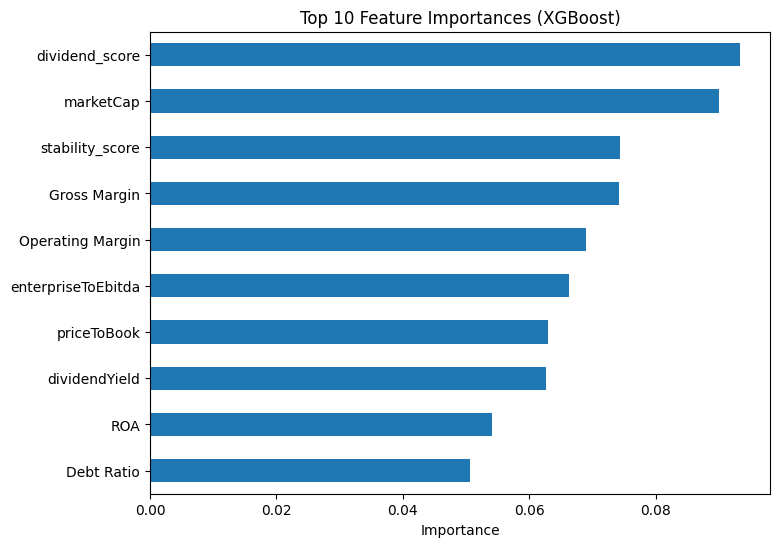

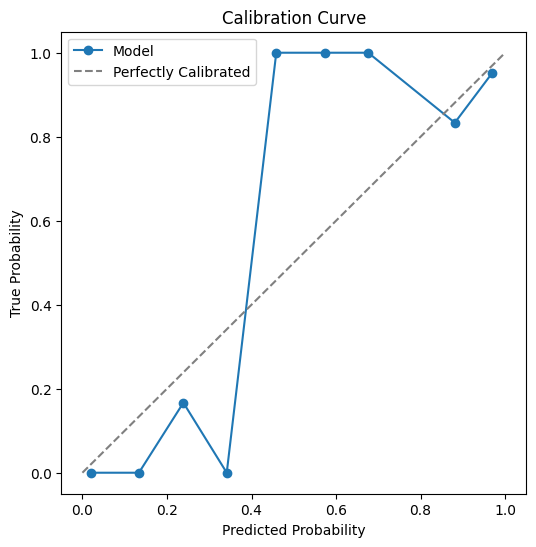

In [22]:
# Checking Feature Importances and Calibration

from sklearn.calibration import calibration_curve

top_n = 10
# Feature Importance
booster = cv_result['model'].named_steps['classifier']
importances = booster.feature_importances_
fi = pd.Series(importances, index=feature_columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
fi.head(top_n).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()

def plot_calibration_curve(y_test, y_proba, n_bins=10):
    """Plot calibration curve"""
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=n_bins)
    
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label="Model")
    plt.plot([0,1],[0,1],'--', color='gray', label="Perfectly Calibrated")
    plt.title("Calibration Curve")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.legend()
    plt.show()

plot_calibration_curve(cv_result["y_test"], cv_result["y_proba"])

In [23]:
# Train on 3 Snapshots, Test on Last with Calibration
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, recall_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

feature_columns = [
    'ROE', 'ROA', 'Profit Margin', 'Operating Margin', 'Gross Margin',
    'Revenue Growth', 'Earnings Growth', 'Debt Ratio', 'Debt to Equity Ratio',
    'Current Ratio', 'trailingPE', 'priceToBook', 'enterpriseToEbitda',
    'marketCap', 'dividendYield',
    'value_score', 'quality_score', 'stability_score', 'has_dividend',
    'dividend_score', 'large_cap', 'sustainable_growth'
]

def train_on_three_test_on_last(splits):
    
    dates = sorted(splits.keys())
    train_dates = dates[:3]
    test_date = dates[3]
    
    print("Training on:", ', '.join(train_dates))
    print("Testing on:", test_date)
    print()
    
    train_list = []
    for date in train_dates:
        train_list.append(splits[date]["train"])
        train_list.append(splits[date]["test"])
    
    train_combined = pd.concat(train_list, ignore_index=True)
    test_combined = pd.concat([splits[test_date]["train"], splits[test_date]["test"]], ignore_index=True)
    
    X_train = train_combined[feature_columns].replace([np.inf, -np.inf], np.nan)
    y_train = train_combined["Buffett_Owned"]
    X_test = test_combined[feature_columns].replace([np.inf, -np.inf], np.nan)
    y_test = test_combined["Buffett_Owned"]
    
    print(f"Train: {X_train.shape}, Labels: {y_train.value_counts().values}")
    print(f"Test: {X_test.shape}, Labels: {y_test.value_counts().values}")
    print()

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('classifier', XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
            random_state=42
        ))
    ])

    cv_roc = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    cv_recall = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=make_scorer(recall_score, pos_label=1))
    cv_f1 = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
    
    print(f"CV - ROC AUC: {cv_roc.mean():.3f} ± {cv_roc.std()*2:.3f}")
    print(f"CV - Recall: {cv_recall.mean():.3f} ± {cv_recall.std()*2:.3f}")
    print(f"CV - F1: {cv_f1.mean():.3f} ± {cv_f1.std()*2:.3f}")
    print()

    pipeline.fit(X_train, y_train)
    
    calibrated_model = CalibratedClassifierCV(estimator=pipeline, method='sigmoid', cv='prefit')
    calibrated_model.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    y_pred_cal = calibrated_model.predict(X_test)
    y_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]

    print("Base Model:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    if len(np.unique(y_test)) > 1:
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}\n")
    
    print("Calibrated Model:")
    print(confusion_matrix(y_test, y_pred_cal))
    print(classification_report(y_test, y_pred_cal))
    if len(np.unique(y_test)) > 1:
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba_cal):.3f}")
    
    return {
        "model": pipeline,
        "calibrated_model": calibrated_model,
        "cv_roc": cv_roc.mean(),
        "cv_recall": cv_recall.mean(),
        "cv_f1": cv_f1.mean(),
        "y_test": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "y_pred_cal": y_pred_cal,
        "y_proba_cal": y_proba_cal,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train
    }

cv_result = train_on_three_test_on_last(splits)

Training on: 2024-08-14, 2024-11-14, 2025-02-14
Testing on: 2025-05-15

Train: (1346, 22), Labels: [1249   97]
Test: (448, 22), Labels: [418  30]

CV - ROC AUC: 0.972 ± 0.084
CV - Recall: 0.786 ± 0.208
CV - F1: 0.802 ± 0.245

Base Model:
[[416   2]
 [  2  28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       418
           1       0.93      0.93      0.93        30

    accuracy                           0.99       448
   macro avg       0.96      0.96      0.96       448
weighted avg       0.99      0.99      0.99       448

ROC AUC: 0.998

Calibrated Model:
[[416   2]
 [  3  27]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       418
           1       0.93      0.90      0.92        30

    accuracy                           0.99       448
   macro avg       0.96      0.95      0.95       448
weighted avg       0.99      0.99      0.99       448

ROC AUC: 0.998


ROC AUC (uncalibrated): 0.998006379585327
ROC AUC (calibrated): 0.9476076555023923
Brier score (uncalibrated): 0.009955660537921364
Brier score (calibrated): 0.011160714285714286

Classification Report (Calibrated):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       418
           1       0.93      0.90      0.92        30

    accuracy                           0.99       448
   macro avg       0.96      0.95      0.95       448
weighted avg       0.99      0.99      0.99       448



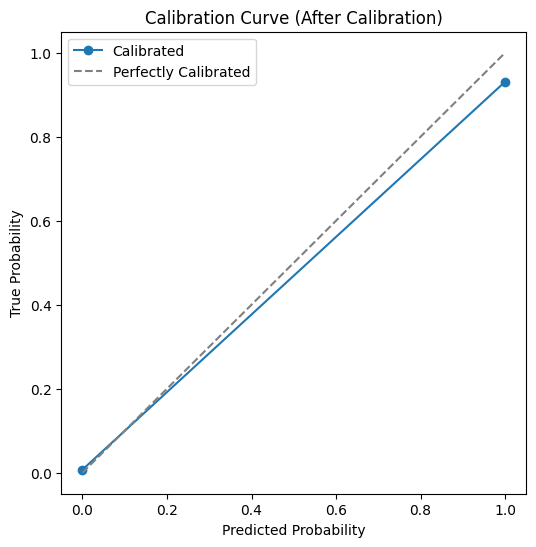

In [24]:
from sklearn.metrics import brier_score_loss, roc_auc_score, classification_report
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Evaluate calibrated probabilities
print("ROC AUC (uncalibrated):", roc_auc_score(cv_result['y_test'], cv_result['y_proba']))
print("ROC AUC (calibrated):", roc_auc_score(cv_result['y_test'], cv_result['y_pred_cal']))

print("Brier score (uncalibrated):", brier_score_loss(cv_result['y_test'], cv_result['y_proba']))
print("Brier score (calibrated):", brier_score_loss(cv_result['y_test'], cv_result['y_pred_cal']))

print("\nClassification Report (Calibrated):")
print(classification_report(cv_result['y_test'], ((cv_result['y_pred_cal']) > 0.5).astype(int)))

# Calibration plot
prob_true, prob_pred = calibration_curve(cv_result['y_test'], (cv_result['y_pred_cal']), n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label="Calibrated")
plt.plot([0,1],[0,1],'--', color='gray', label="Perfectly Calibrated")
plt.title("Calibration Curve (After Calibration)")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.legend()
plt.show()


In [29]:
def prepare_sp500_for_prediction(sp_final_df, target_date='2025-03-31', buffett_owned_tickers=None):
    """Prepare S&P 500 data with all necessary features for specific date"""
    
    df = sp_final_df.copy()
    
    # Filter for specific date
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'] == target_date]
    
    print(f"Filtered to date: {target_date}")
    print(f"Found {len(df)} stocks for this date")
    
    # Remove stocks Buffett already owns
    if buffett_owned_tickers is not None:
        df = df[~df['ticker'].isin(buffett_owned_tickers)]
        print(f"After removing Buffett stocks: {len(df)} remaining")
    
    # Calculate value_score
    df['value_score'] = np.where(
        (df['trailingPE'] > 0) & (df['priceToBook'] > 0),
        1 / (df['trailingPE'] * df['priceToBook'] + 0.01),
        0
    )
    
    # Calculate quality_score
    df['quality_score'] = (
        df['ROE'].fillna(0) * 0.3 + 
        df['ROA'].fillna(0) * 0.3 + 
        df['Profit Margin'].fillna(0) * 0.4
    )
    
    # Calculate stability_score
    df['stability_score'] = 1 / (df['Debt to Equity Ratio'].fillna(0) + 1)
    
    # Dividend features
    df['has_dividend'] = (df['dividendYield'] > 0).astype(int)
    df['dividend_score'] = df['dividendYield'].fillna(0)
    
    # Market cap features
    df['large_cap'] = (df['marketCap'] > df['marketCap'].median()).astype(int)
    
    # Sustainable growth
    df['sustainable_growth'] = np.where(
        (df['Revenue Growth'] > 0) & (df['Earnings Growth'] > 0) & 
        (df['Debt Ratio'] < 0.5),
        1, 0
    )
    
    # Buffett features
    df['debt_ratio_inv'] = 1 / (df['Debt Ratio'] + 0.01)
    df['roe_stability'] = df['ROE'] * df['stability_score']
    df['quality_value'] = df['quality_score'] * df['value_score']
    df['buffett_score'] = (
        df['ROE'] * 0.3 + df['debt_ratio_inv'] * 0.2 + 
        df['stability_score'] * 0.3 + df['dividend_score'] * 0.2
    )
    
    return df

sp500_df = prepare_sp500_for_prediction(sp_final_df) 
print(sp500_df)
print(sp500_df.columns)

Filtered to date: 2025-03-31
Found 415 stocks for this date
     ticker       date       ROE       ROA  Profit Margin  Operating Margin  \
11     ABBV 2025-03-31  0.905634  0.009444       0.096380          0.298359   
18     ABNB 2025-03-31  0.019403  0.006146       0.067782          0.016725   
25      ABT 2025-03-31  0.027146  0.016268       0.127920          0.163449   
32     ACGL 2025-03-31  0.027709  0.007635       0.125000               NaN   
58      ADM 2025-03-31  0.013337  0.005524       0.014622          0.012292   
...     ...        ...       ...       ...            ...               ...   
3228   WYNN 2025-03-31 -0.201695  0.005717       0.042782          0.161066   
3235    XEL 2025-03-31  0.024389  0.006639       0.123656          0.173323   
3242    XOM 2025-03-31  0.029358  0.017068       0.095154          0.121469   
3249    XYL 2025-03-31  0.015625  0.010206       0.081682          0.121798   
3256    XYZ 2025-03-31  0.008844  0.005217       0.032897          0.08

In [ ]:
# Using the model for prediction
import pandas as pd
import numpy as np

def sp500_prediction(df, model, feature_columns, top_n=10, threshold=0.5, target_date=None):
    """Predict Buffett ownership for S&P 500 stocks and display top candidates."""
    
    df = df.copy()
    X = df[feature_columns].replace([np.inf, -np.inf], np.nan)
    
    # Predict probabilities
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba > threshold).astype(int)
    
    # Add predictions back into dataframe
    df['Buffett_Owned'] = y_pred
    df['buffett_probability'] = y_proba
    
    # Sort and select top stocks
    results_df = df.sort_values('buffett_probability', ascending=False)
    top_stocks = results_df.head(top_n)
    
    # Print header
    print(f"\n{'='*100}")
    print(f"TOP {top_n} STOCKS BUFFETT LIKELY WOULD BUY FROM S&P 500", end="")
    if target_date:
        print(f" ({target_date})")
    else:
        print()
    print(f"{'='*100}\n")
    
    # Show all columns of top N stocks
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.max_rows', None)
    
    print(top_stocks.to_string(index=False))
    
    print(f"\n{'='*100}")
    return results_df

sp500_ranking = sp500_prediction(
    df=sp500_df,
    model=cv_result['model'],
    feature_columns=feature_columns,
    top_n=10,
    target_date='2025-10-03'
)
# print(sp500_ranking.head())



TOP 10 BUFFETT-STYLE STOCKS FROM S&P 500 (2025-10-03)

ticker       date       ROE      ROA  Profit Margin  Operating Margin  Gross Margin  Revenue Growth  Earnings Growth  Debt Ratio  Debt to Equity Ratio  Current Ratio  Free Cash Flow  trailingPE  priceToBook  enterpriseToEbitda     marketCap  dividendYield  value_score  quality_score  stability_score  has_dividend  dividend_score  large_cap  sustainable_growth  debt_ratio_inv  roe_stability  quality_value  buffett_score  Buffett_Owned  buffett_probability
  META 2025-03-31  0.089953 0.059398       0.393345          0.414875      0.821052       -0.125473        -0.201267    0.176719              0.267628       2.662349    1.108500e+10   26.813068     9.527679              19.709 1855717900288           0.28     0.003914       0.202143         0.788875             1            0.28          1                   0        5.355637       0.070962       0.000791       1.390776              1             0.505053
  ENPH 2025-03-31  0.03667